## GaitSet Implements

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tordata

import torch.autograd as autograd
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from network.network import SetNet
from network.network_layer import *
from network.triplet_loss import *
from utils.triplet_sampler import *
from utils.data_load import *

from datetime import datetime

import multiprocessing as mp

### Settings

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### data

In [3]:
train_dataset, test_dataset = load_OU_ISIR('./data/OU_ISIR/npy/', False)

In [4]:
triplet_sampler = TripletSampler(train_dataset, [4, 8])

train_loader = tordata.DataLoader(dataset=train_dataset, batch_sampler=triplet_sampler, collate_fn=collate_fnn)
test_loader = tordata.DataLoader(dataset=test_dataset, batch_size=1, sampler=tordata.sampler.SequentialSampler(test_dataset), collate_fn=collate_fnn)

### model

In [5]:
encoder = SetNet(128).to(device)

### loss

In [8]:
criterion = TripletLoss(8, 0.2).to(device)
optimizer = optim.Adam([{'params':encoder.parameters()},], lr=3e-7)

### train

In [9]:
encoder.load_state_dict(torch.load('./checkpoint/OU_ISIR_Encoder.ptm'))
optimizer.load_state_dict(torch.load('./checkpoint/OU_ISIR_Optimizer.ptm'))

In [ ]:
total_iter = 100000
all_losses = []

pool = mp.Pool(processes=6)

s_time = datetime.now()
for i, (seqs, view, label) in enumerate(train_loader):

    feature = encoder(seqs)

    tmp_label_set = list(train_dataset.set_label)
    tmp_label_set.sort()

    target_label = [tmp_label_set.index(l) for l in label]
    target_label = autograd.Variable(torch.from_numpy(np.array(target_label))).to(device)

    triplet_feature = feature.permute(1, 0, 2).contiguous()
    triplet_label = target_label.unsqueeze(0).repeat(triplet_feature.size(0), 1)

    hard_loss, dist_mean = criterion(triplet_feature, triplet_label)

    loss = hard_loss.mean()
    
    if loss > 1e-9:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        

    if (i+1) % 100 == 0:
        print('Step [{}], Elapsed Time [{}], Loss [{}]'.format(i+1, datetime.now() - s_time, loss))
        all_losses.append(loss)
        s_time = datetime.now()
        
    if (i+1) == total_iter:
        break
        
pool.close()
pool.join()

Step [100], Elapsed Time [0:01:10.137295], Loss [0.20000015199184418]
Step [200], Elapsed Time [0:00:38.019016], Loss [0.2000000923871994]
Step [300], Elapsed Time [0:00:32.752270], Loss [0.2000001221895218]
Step [400], Elapsed Time [0:00:30.782326], Loss [0.2000001221895218]
Step [500], Elapsed Time [0:00:30.766177], Loss [0.2000001221895218]
Step [600], Elapsed Time [0:00:30.822944], Loss [0.2000001221895218]
Step [700], Elapsed Time [0:00:30.876721], Loss [0.2000001221895218]
Step [800], Elapsed Time [0:00:30.777020], Loss [0.2000001221895218]
Step [900], Elapsed Time [0:00:30.819044], Loss [0.20000013709068298]
Step [1000], Elapsed Time [0:00:30.777726], Loss [0.2000001072883606]
Step [1100], Elapsed Time [0:00:30.774788], Loss [0.20000013709068298]
Step [1200], Elapsed Time [0:00:30.813654], Loss [0.20000013709068298]
Step [1300], Elapsed Time [0:00:30.855591], Loss [0.2000001221895218]
Step [1400], Elapsed Time [0:00:30.858564], Loss [0.2000000923871994]
Step [1500], Elapsed Time

In [9]:
torch.save(encoder.state_dict(), os.path.join('./checkpoint/','OU_ISIR_Encoder_1.ptm'))
torch.save(optimizer.state_dict(), os.path.join('./checkpoint/','OU_ISIR_Optimizer_1.ptm'))

In [10]:
def drawLoss(loss_dict):
    plt.style.use(['ggplot'])
    
    for key, value in loss_dict.items():
        x = np.arange(len(loss_dict[key]))
        plt.plot(x, loss_dict[key], label=key)
    
    plt.xlabel("train step")
    plt.ylabel("loss")
    
    plt.show()

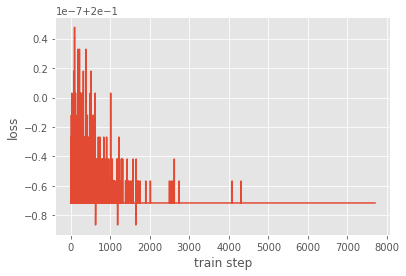

In [13]:
drawLoss({'Loss':all_losses[5000:]})

### test

In [78]:
pool = mp.Pool(processes=6)

feature_list = []
view_list = []
label_list = []

s_time = datetime.now()
for i, (seqs, view, label) in enumerate(test_loader):

    feature = encoder(seqs)
    
    n, num_bins, _ = feature.size()
    feature_list.append(feature.view(n, -1).data.cpu().numpy())
    view_list += view
    label_list += label
    
test = np.concatenate(feature_list, 0)
        
pool.close()
pool.join()

In [80]:
def cuda_dist(x, y):
    x = torch.from_numpy(x).cuda()
    y = torch.from_numpy(y).cuda()
    dist = torch.sum(x ** 2, 1).unsqueeze(1) + torch.sum(y ** 2, 1).unsqueeze(
        1).transpose(0, 1) - 2 * torch.matmul(x, y.transpose(0, 1))
    dist = torch.sqrt(F.relu(dist))
    return dist

In [81]:
def evaluation(feature, view, label):
    
    label = np.array(label)
    view_list = list(set(view))
    view_list.sort()
    view_num = len(view_list)
    sample_num = len(feature)

    probe_seq_list = ['00']
    gallery_seq_list = ['01']

    num_rank = 5
    acc = np.zeros([len(probe_seq_list), view_num, view_num, num_rank])
    for (p, probe_seq) in enumerate(probe_seq_list):
        for gallery_seq in gallery_seq_list:
            for (v1, probe_view) in enumerate(view_list):
                for (v2, gallery_view) in enumerate(view_list):
                    gseq_mask = np.isin(view, [gallery_view])
                    gallery_x = feature[gseq_mask, :]
                    gallery_y = label[gseq_mask]

                    pseq_mask = np.isin(view, [probe_view])
                    probe_x = feature[pseq_mask, :]
                    probe_y = label[pseq_mask]

                    dist = cuda_dist(probe_x, gallery_x)
                    idx = dist.sort(1)[1].cpu().numpy()
                    acc[p, v1, v2, :] = np.round(
                        np.sum(np.cumsum(np.reshape(probe_y, [-1, 1]) == gallery_y[idx[:, 0:num_rank]], 1) > 0,
                               0) * 100 / dist.shape[0], 2)

    return acc

In [82]:
def de_diag(acc, each_angle=False):
    result = np.sum(acc - np.diag(np.diag(acc)), 1) / 10.0
    if not each_angle:
        result = np.mean(result)
    return result

In [83]:
acc = evaluation(test, view_list, label_list)
print(acc.shape)
print(acc)

(1, 14, 14, 5)
[[[[100.   100.   100.   100.   100.  ]
   [ 53.66  65.85  80.49  82.93  87.8 ]
   [ 31.71  41.46  56.1   65.85  75.61]
   [ 21.95  26.83  34.15  39.02  43.9 ]
   [ 14.63  24.39  34.15  41.46  46.34]
   [ 17.07  26.83  39.02  53.66  56.1 ]
   [  9.76  21.95  26.83  41.46  43.9 ]
   [ 39.02  58.54  63.41  68.29  68.29]
   [ 43.9   53.66  63.41  63.41  70.73]
   [ 31.71  46.34  58.54  65.85  70.73]
   [ 17.07  24.39  36.59  41.46  48.78]
   [ 14.63  34.15  43.9   48.78  63.41]
   [ 19.51  36.59  39.02  43.9   51.22]
   [ 14.63  17.07  26.83  41.46  53.66]]

  [[ 53.49  74.42  83.72  83.72  86.05]
   [100.   100.   100.   100.   100.  ]
   [ 76.74  95.35  95.35  95.35  97.67]
   [ 23.26  37.21  41.86  48.84  67.44]
   [ 18.6   32.56  44.19  48.84  58.14]
   [  6.98  25.58  39.53  48.84  60.47]
   [  6.98  25.58  30.23  37.21  48.84]
   [ 41.86  48.84  60.47  62.79  69.77]
   [ 41.86  60.47  65.12  72.09  79.07]
   [ 41.86  51.16  60.47  69.77  81.4 ]
   [ 27.91  39.53  53.4

In [84]:
test_acc = acc[0,:,:,4]
result = test_acc - np.diag(np.diag(test_acc))
print(len(result), len(result[0]))
result = np.mean(result, 0)
print(result)

14 14
[54.325      61.15857143 68.93642857 53.77571429 62.47714286 60.91857143
 54.85142857 55.89785714 66.78285714 68.82       63.775      66.23642857
 66.31357143 59.54142857]


In [45]:
for i in range(1):
    print('===Rank-%d (Exclude identical-view cases)===' % (i + 1))
    print(de_diag(acc[0, :, :, i]))

===Rank-1 (Exclude identical-view cases)===
22.975
